In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from keras.models import Model
from keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
data1 = pd.read_csv('/datasets/bacteria_classification/data1.csv')
data2 = pd.read_csv('/datasets/bacteria_classification/data2.csv')

data = pd.concat([data1,data2],ignore_index=True)

In [3]:
# Encoding our string class values to integer values
encoder = LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])

In [4]:
# Splitting our data into a training set (80%) and testing set (20%)
train, test = train_test_split(data,test_size=0.2,stratify=data['target'],random_state=42)

In [5]:
# Removing duplicates while assigning sample weight to each sample
train2 = pd.DataFrame(
    [list(tup) for tup in train.value_counts().index.values],
    columns = train.columns
)
train2['sample_weight'] = train.value_counts().values

In [6]:
Xtrain = train2.drop(['target','sample_weight'],axis=1)
ytrain = train2['target']
sample_weights = train2['sample_weight']

Xtest = test.drop('target',axis=1)
ytest = test['target']

# Logistic Regression

In [7]:
params = {'max_iter':[10,100,200,300,500,800,1000,1500,2000,2500,10000]}

In [8]:
gscv_lr = GridSearchCV(LogisticRegression(random_state=42),params,cv=3,scoring='accuracy',verbose=2,return_train_score=True,n_jobs=-1)

clf_lr = gscv_lr.fit(Xtrain,ytrain,sample_weight=sample_weights)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


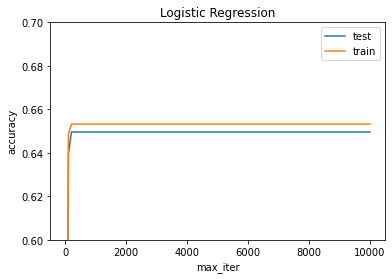

In [9]:
test_scores_lr = clf_lr.cv_results_['mean_test_score']
train_scores_lr = clf_lr.cv_results_['mean_train_score'] 

plt.plot(params['max_iter'],test_scores_lr, label='test')
plt.plot(params['max_iter'],train_scores_lr, label='train')
plt.legend(loc='best')
plt.xlabel("max_iter")
plt.ylabel("accuracy")
plt.ylim([0.6,0.7])
plt.title("Logistic Regression")
plt.show()

In [10]:
clf_lr.best_estimator_

LogisticRegression(max_iter=200, random_state=42)

# XGBoosting

In [7]:
params = {
    'max_depth':[2,3],
    'learning_rate':[0.001,0.01,0.1]
}

In [8]:
model_xg = XGBClassifier(
    base_score=0.5,
    gamma=0,
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    n_estimators=100,
    n_jobs=-1,
    objective='multi:softprob',
    random_state=42,
    seed=None,
    subsample=1,
    verbosity=1,
    use_label_encoder=False
)

In [9]:
gscv_xg = GridSearchCV(model_xg,params,cv=3,scoring='accuracy',verbose=2,return_train_score=True,n_jobs=-1)

clf_xg = gscv_xg.fit(Xtrain,ytrain,sample_weight=sample_weights)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[13:30:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ...................learning_rate=0.001, max_depth=3; total time=18.1min
[13:48:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................learning_rate=0.01, max_depth=3; total time=18.2min
[13:30:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..........

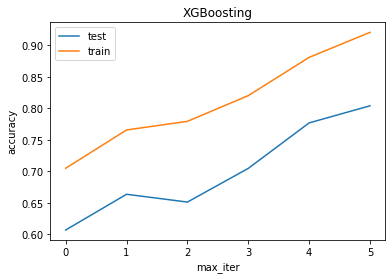

In [10]:
test_scores_xg = clf_xg.cv_results_['mean_test_score']
train_scores_xg = clf_xg.cv_results_['mean_train_score'] 

plt.plot(test_scores_xg, label='test')
plt.plot(train_scores_xg, label='train')
plt.legend(loc='best')
plt.xlabel("max_iter")
plt.ylabel("accuracy")
plt.title("XGBoosting")
plt.show()

In [11]:
clf_xg.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

[13:30:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ...................learning_rate=0.001, max_depth=2; total time=11.7min
[13:42:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................learning_rate=0.01, max_depth=2; total time=12.3min
[13:54:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................learning_rate=0.1, max_depth=2; total time=11.7mi

# Random Forest

In [12]:
params = {
    'max_depth':[2,3,None]
}

In [13]:
model_rf = RandomForestClassifier(
    n_estimators = 1500,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    warm_start=False,
    min_samples_split=2
)

In [14]:
gscv_rf = GridSearchCV(model_rf,params,cv=3,scoring='accuracy',verbose=2,return_train_score=True,n_jobs=-1)

clf_rf = gscv_rf.fit(Xtrain,ytrain,sample_weight=sample_weights)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ........................................max_depth=3; total time= 4.9min
[CV] END ........................................max_depth=3; total time= 5.2min
[CV] END ........................................max_depth=3; total time= 5.8min
[CV] END ........................................max_depth=2; total time= 4.5min
[CV] END .....................................max_depth=None; total time= 8.6min
[CV] END ........................................max_depth=2; total time= 4.4min
[CV] END .....................................max_depth=None; total time= 9.0min
[CV] END ........................................max_depth=2; total time= 4.7min
[CV] END .....................................max_depth=None; total time= 8.6min


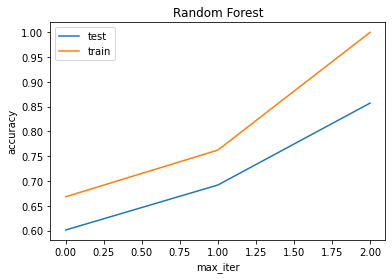

In [15]:
test_scores_rf = clf_rf.cv_results_['mean_test_score']
train_scores_rf = clf_rf.cv_results_['mean_train_score'] 

plt.plot(test_scores_rf, label='test')
plt.plot(train_scores_rf, label='train')
plt.legend(loc='best')
plt.xlabel("max_iter")
plt.ylabel("accuracy")
plt.title("Random Forest")
plt.show()

In [16]:
clf_rf.best_estimator_

RandomForestClassifier(n_estimators=1500, n_jobs=-1, oob_score=True,
                       random_state=42)